In [1]:
import boto3
import pandas as pd
from io import StringIO
import time
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np



In [2]:
# Set up the S3 client
s3_client = boto3.client('s3')

# Define the bucket name and file key
bucket_name = 'beamdata-pocketride'
file_key = 'Chicago/combined_data_2024_04.csv'

# Step 1: Start the timer
start_time = time.time()

# Step 2: Read the CSV file from S3
response = s3_client.get_object(Bucket=bucket_name, Key=file_key)

# Check if the file was fetched successfully
if response.get("ResponseMetadata", {}).get("HTTPStatusCode") == 200:
    # Load the CSV content into a pandas DataFrame
    df = pd.read_csv(StringIO(response['Body'].read().decode('utf-8')))
    
    # Step 3: Stop the timer
    end_time = time.time()
    
    # Calculate the total time taken
    time_taken = end_time - start_time
    
    # Display the DataFrame and the time taken
    df.head()
    print(f"\nTime taken to read the file from S3: {time_taken:.2f} seconds")
else:
    print("Failed to fetch the file from S3.")


Time taken to read the file from S3: 94.00 seconds


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7371563 entries, 0 to 7371562
Data columns (total 24 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   trip_id                     object 
 1   trip_start_timestamp        object 
 2   trip_end_timestamp          object 
 3   trip_seconds                float64
 4   trip_miles                  float64
 5   percent_time_chicago        float64
 6   percent_distance_chicago    float64
 7   pickup_census_tract         float64
 8   dropoff_census_tract        float64
 9   pickup_community_area       float64
 10  dropoff_community_area      float64
 11  fare                        float64
 12  tip                         float64
 13  additional_charges          float64
 14  trip_total                  float64
 15  shared_trip_authorized      bool   
 16  shared_trip_match           bool   
 17  trips_pooled                int64  
 18  pickup_centroid_latitude    float64
 19  pickup_centroid_longi

# Functions for z-score and IQR

In [4]:
def analyze_column(df, column_name, z_threshold=3, iqr_factor=1.5):
    # Drop null values
    column_data = df[column_name].dropna()

    # Calculate original skewness
    original_skewness = column_data.skew()

    # Apply log transformation
    column_data_log = np.log1p(column_data)  # log1p is used to handle zero values

    # Calculate log skewness
    log_skewness = column_data_log.skew()

    # Calculate z-scores for log-transformed column
    z_scores_log = stats.zscore(column_data_log)

    # Calculate IQR for log-transformed column
    Q1 = column_data_log.quantile(0.25)
    Q3 = column_data_log.quantile(0.75)
    IQR = Q3 - Q1

    # Determine bounds for outliers
    lower_bound = Q1 - iqr_factor * IQR
    upper_bound = Q3 + iqr_factor * IQR

    # Flag Z-score and IQR outliers
    z_outliers = np.abs(z_scores_log) > z_threshold
    iqr_outliers = (column_data_log < lower_bound) | (column_data_log > upper_bound)

    # Calculate confidence scores
    z_confidence = np.clip(np.abs(z_scores_log) / z_threshold, 0, 1)
    iqr_confidence = np.clip(
        np.where(column_data_log < lower_bound, (lower_bound - column_data_log) / IQR,
                 np.where(column_data_log > upper_bound, (column_data_log - upper_bound) / IQR, 0)),
        0, 1
    )

    # Combined confidence score
    combined_confidence = (z_confidence + iqr_confidence) / 2

    # Add new columns to the DataFrame
    df[f'IQR_{column_name}'] = iqr_outliers
    df[f'Z_OUTLIER_{column_name}'] = z_outliers
    df[f'CONFIDENCE_{column_name}'] = combined_confidence
    df[f'Z_LOG_SCORE_{column_name}'] = z_scores_log

    return original_skewness, log_skewness

def plot_histograms(df, column_name, original_skewness, log_skewness):
    column_data = df[column_name].dropna()
    column_data_log = np.log1p(column_data)

    # Plot histograms
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(column_data, bins=50, color='blue', alpha=0.7)
    plt.title(f'Original {column_name} Histogram')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(column_data_log, bins=50, color='green', alpha=0.7)
    plt.title(f'Log-transformed {column_name} Histogram')
    plt.xlabel(f'Log({column_name})')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    print(f"Original Skewness of {column_name}: {original_skewness}")
    print(f"Log-transformed Skewness of {column_name}: {log_skewness}")



# Trip Miles

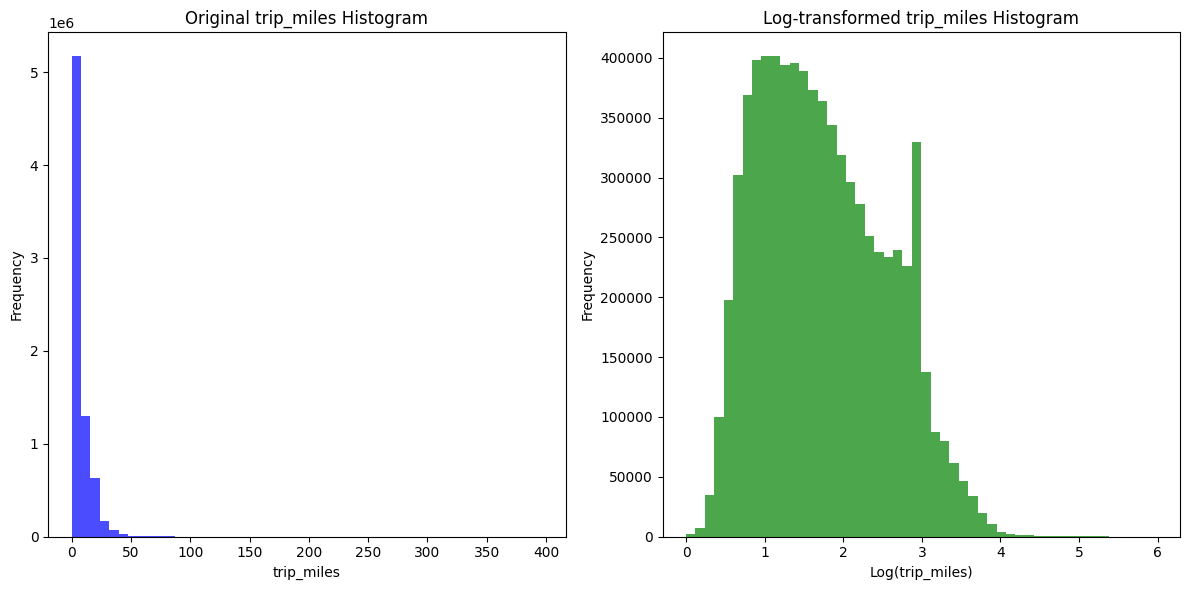

Original Skewness of trip_miles: 3.439457824269097
Log-transformed Skewness of trip_miles: 0.3756453853037757


In [5]:
# Example usage
original_skewness, log_skewness = analyze_column(df, 'trip_miles')
plot_histograms(df, 'trip_miles', original_skewness, log_skewness)

# Trip time

In [7]:
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])
df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'])

In [8]:
# Extract day of the week, day of the month, hour, and minute for trip_start_timestamp
df['start_day_of_week'] = df['trip_start_timestamp'].dt.dayofweek
df['start_day_of_month'] = df['trip_start_timestamp'].dt.day
df['start_hour'] = df['trip_start_timestamp'].dt.hour
df['start_minute'] = df['trip_start_timestamp'].dt.minute

# Extract day of the week, day of the month, hour, and minute for trip_end_timestamp
df['end_day_of_week'] = df['trip_end_timestamp'].dt.dayofweek
df['end_day_of_month'] = df['trip_end_timestamp'].dt.day
df['end_hour'] = df['trip_end_timestamp'].dt.hour
df['end_minute'] = df['trip_end_timestamp'].dt.minute

In [10]:
# Example usage
original_skewness, log_skewness = analyze_column(df, 'trip_time')
plot_histograms(df, 'trip_time', original_skewness, log_skewness)

KeyError: 'trip_time'

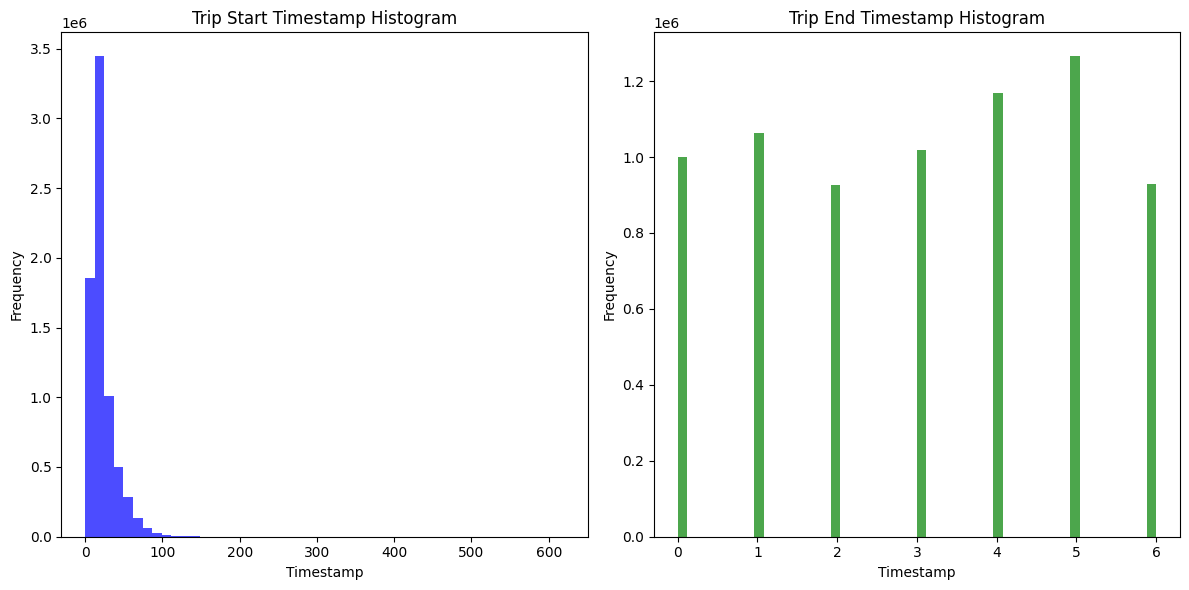

In [19]:
# Assuming df is your DataFrame


# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['trip_total'], bins=50, color='blue', alpha=0.7)
plt.title('Trip Start Timestamp Histogram')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['start_day_of_week'], bins=50, color='green', alpha=0.7)
plt.title('Trip End Timestamp Histogram')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
df['trip_total']

In [57]:
df.columns

Index(['trip_id', 'trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds',
       'trip_miles', 'percent_time_chicago', 'percent_distance_chicago',
       'pickup_census_tract', 'dropoff_census_tract', 'pickup_community_area',
       'dropoff_community_area', 'fare', 'tip', 'additional_charges',
       'trip_total', 'shared_trip_authorized', 'shared_trip_match',
       'trips_pooled', 'pickup_centroid_latitude', 'pickup_centroid_longitude',
       'pickup_centroid_location', 'dropoff_centroid_latitude',
       'dropoff_centroid_longitude', 'dropoff_centroid_location',
       'start_day_of_week', 'start_day_of_month', 'start_hour', 'start_minute',
       'end_day_of_week', 'end_day_of_month', 'end_hour', 'end_minute',
       'trip_total_zscore', 'trip_total_log', 'trip_total_log_zscore',
       'IQR_outlier', 'IQR_trip_miles', 'Z_LOG_SCORE_trip_miles'],
      dtype='object')

In [34]:
# Assuming df is your DataFrame
trip_total = df['trip_total'].dropna()

# Calculate IQR
Q1 = trip_total.quantile(0.25)
Q3 = trip_total.quantile(0.75)
IQR = Q3 - Q1

print(f"IQR: {IQR}")

IQR: 13.92


In [35]:
trip_total.isnull().sum()

np.int64(0)

In [36]:
print(f"Null values in trip_total: {trip_total.isnull().sum()}")

Null values in trip_total: 0


In [37]:
# Remove or fill null values
trip_total = trip_total.dropna()  # or use trip_total.fillna(trip_total.mean()) to fill with mean

# Recalculate z-scores
z_scores = stats.zscore(trip_total)

In [38]:
df['trip_total_zscore'] = z_scores

In [39]:
df[['trip_total', 'trip_total_zscore']].head()

,trip_total,trip_total_zscore
0,8.01,-0.879778
1,16.23,-0.381118
2,8.73,-0.836100
3,46.15,1.433953
4,5.65,-1.022945


In [43]:
# Assuming df is your DataFrame
trip_total = df['trip_total']

# Check for null values
trip_total = trip_total.dropna()

# Apply log transformation to reduce skewness
trip_total_log = np.log1p(trip_total)  # log1p is used to handle zero values

# Recalculate z-scores after transformation
z_scores_log = stats.zscore(trip_total_log)

# Add transformed trip_total and z-scores to the DataFrame
df.loc[trip_total.index, 'trip_total_log'] = trip_total_log
df.loc[trip_total.index, 'trip_total_log_zscore'] = z_scores_log

# Verify the changes
df[['trip_total', 'trip_total_log', 'trip_total_log_zscore']].head()

,trip_total,trip_total_log,trip_total_log_zscore
0,8.01,2.198335,-1.362411
1,16.23,2.846652,-0.231882
2,8.73,2.275214,-1.228350
3,46.15,3.853334,1.523560
4,5.65,1.894617,-1.892031


Original Skewness: 2.727455119558864
Log-transformed Skewness: 0.40709005546840943


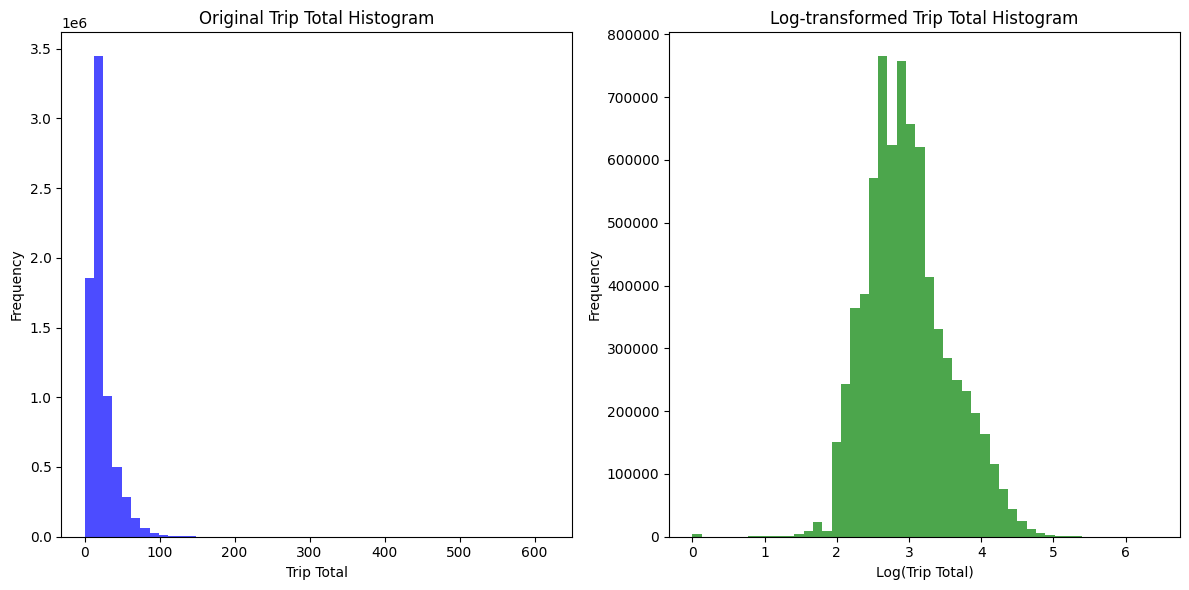

In [50]:
# Assuming df is your DataFrame
trip_total = df['trip_total'].dropna()

# Apply log transformation
trip_total_log = np.log1p(trip_total)  # log1p is used to handle zero values

# Calculate skewness
original_skewness = trip_total.skew()
log_skewness = trip_total_log.skew()

print(f"Original Skewness: {original_skewness}")
print(f"Log-transformed Skewness: {log_skewness}")

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(trip_total, bins=50, color='blue', alpha=0.7)
plt.title('Original Trip Total Histogram')
plt.xlabel('Trip Total')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(trip_total_log, bins=50, color='green', alpha=0.7)
plt.title('Log-transformed Trip Total Histogram')
plt.xlabel('Log(Trip Total)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [52]:
# Calculate IQR for log-transformed trip_total
Q1 = trip_total_log.quantile(0.25)
Q3 = trip_total_log.quantile(0.75)
IQR = Q3 - Q1

# Determine bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flag outliers
df['IQR_outlier'] = (trip_total_log < lower_bound) | (trip_total_log > upper_bound)

In [53]:
df[['trip_total', 'trip_total_log', 'trip_total_log_zscore','IQR_outlier']].head()

,trip_total,trip_total_log,trip_total_log_zscore,IQR_outlier
0,8.01,2.198335,-1.362411,False
1,16.23,2.846652,-0.231882,False
2,8.73,2.275214,-1.228350,False
3,46.15,3.853334,1.523560,False
4,5.65,1.894617,-1.892031,False
